## Analysis of an E-commerce Dataset Part 3 (s2 2023)


In this Portfolio task, you will continue working with the dataset you have used in portfolio 2. But the difference is that the ratings have been converted to like (with score 1) and dislike (with score 0). Your task is to train classification models such as KNN to predict whether a user like or dislike an item.  


The header of the csv file is shown below. 

| userId | timestamp | review | item | helpfulness | gender | category | item_id | item_price | user_city | rating |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
    
Your high level goal in this notebook is to try to build and evaluate predictive models for 'rating' from other available features - predict the value of the like (corresponding to rating 1) and dislike (corresponding to rating 0) in the data from some of the other fields. More specifically, you need to complete the following major steps: 
1) Explore the data. Clean the data if necessary. For example, remove abnormal instanaces and replace missing values.
2) Convert object features into digit features by using an encoder
3) Study the correlation between these features. 
4) Split the dataset and train a logistic regression model to predict 'rating' based on other features. Evaluate the accuracy of your model.
5) Split the dataset and train a KNN model to predict 'rating' based on other features. You can set K with an ad-hoc manner in this step. Evaluate the accuracy of your model.
6) Tune the hyper-parameter K in KNN to see how it influences the prediction performance

Note 1: We did not provide any description of each step in the notebook. You should learn how to properly comment your notebook by yourself to make your notebook file readable. 

Note 2: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use both ___Logistic Regression model___ and ___KNN model___ for solving this classification problem. Accordingly, discuss the performance of these two methods.
    

In [1]:
#import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
from textblob import TextBlob

## Initializing the Data

#### 1. Importing the dataset

Following standard procedure, the dataset is imported to the workspace for processing.

In [2]:
data_set = 'data/portfolio_3.csv'
data_frame = pd.read_csv(data_set)
data_frame.head()

,userId,timestamp,review,item,helpfulness,gender,category,item_id,item_price,user_city,rating
0,4081,71900,Not always McCrap,McDonald's,3,M,Restaurants & Gourmet,41,30.74,4,1
1,4081,72000,I dropped the chalupa even before he told me to,Taco Bell,4,M,Restaurants & Gourmet,74,108.30,4,0
2,4081,72000,The Wonderful World of Wendy,Wendy's,4,M,Restaurants & Gourmet,84,69.00,4,1
3,4081,100399,They actually did it,"South Park: Bigger, Longer & Uncut",3,M,Movies,68,143.11,4,1
4,4081,100399,Hey! Gimme some pie!,American Pie,3,M,Movies,6,117.89,4,0


#### 2. Cleaning the dataset

All null values are dropped from the dataset. They will only create a hindrance in further processing.

In [3]:
data_frame = data_frame.dropna()
data_frame.head()

,userId,timestamp,review,item,helpfulness,gender,category,item_id,item_price,user_city,rating
0,4081,71900,Not always McCrap,McDonald's,3,M,Restaurants & Gourmet,41,30.74,4,1
1,4081,72000,I dropped the chalupa even before he told me to,Taco Bell,4,M,Restaurants & Gourmet,74,108.30,4,0
2,4081,72000,The Wonderful World of Wendy,Wendy's,4,M,Restaurants & Gourmet,84,69.00,4,1
3,4081,100399,They actually did it,"South Park: Bigger, Longer & Uncut",3,M,Movies,68,143.11,4,1
4,4081,100399,Hey! Gimme some pie!,American Pie,3,M,Movies,6,117.89,4,0


#### 3. Encoding object features into numerical values

All non numeric features are encoded into numerical values, same as done in previous protfolios. "gender" and "category" are assigned numeric values. "review" is converted using sentiments involved in the text rather than simply assigning a numeric value to the text. Positive reviews result in higher sentiment.

In [4]:
# Initialize OrdinalEncoder
encoder = OrdinalEncoder()

# Fit and transform the gender and category columns
data_frame['gender_encoded'] = encoder.fit_transform(data_frame[['gender']])
data_frame['category_encoded'] = encoder.fit_transform(data_frame[['category']])
data_frame['review_encoded'] = data_frame['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
data_frame.head()

,userId,timestamp,review,item,helpfulness,gender,category,item_id,item_price,user_city,rating,gender_encoded,category_encoded,review_encoded
0,4081,71900,Not always McCrap,McDonald's,3,M,Restaurants & Gourmet,41,30.74,4,1,1.0,8.0,0.0
1,4081,72000,I dropped the chalupa even before he told me to,Taco Bell,4,M,Restaurants & Gourmet,74,108.30,4,0,1.0,8.0,0.0
2,4081,72000,The Wonderful World of Wendy,Wendy's,4,M,Restaurants & Gourmet,84,69.00,4,1,1.0,8.0,1.0
3,4081,100399,They actually did it,"South Park: Bigger, Longer & Uncut",3,M,Movies,68,143.11,4,1,1.0,5.0,0.0
4,4081,100399,Hey! Gimme some pie!,American Pie,3,M,Movies,6,117.89,4,0,1.0,5.0,0.0


## Studying Correlation

#### 1. Observing the Correlation between the relevant features

Only some of the features are selected for correlation. The selected features are all logically obvious. They are | review | helpfulness | gender | category | rating |

In [5]:
corr_columns = ['rating', 'helpfulness', 'gender_encoded','category_encoded', 'review_encoded']
corr_data = data_frame[corr_columns]
corr_matrix = corr_data.corr()

#### 2. Visualizing Correlation Map

The correlation heatmap shows how each feature is affected by the rest. rating and review fields have the highest correlation, even though it is quite low. The rest are also very low correlation values. At this stage, I estimate that the prediction models will not be sufficiently accurate.

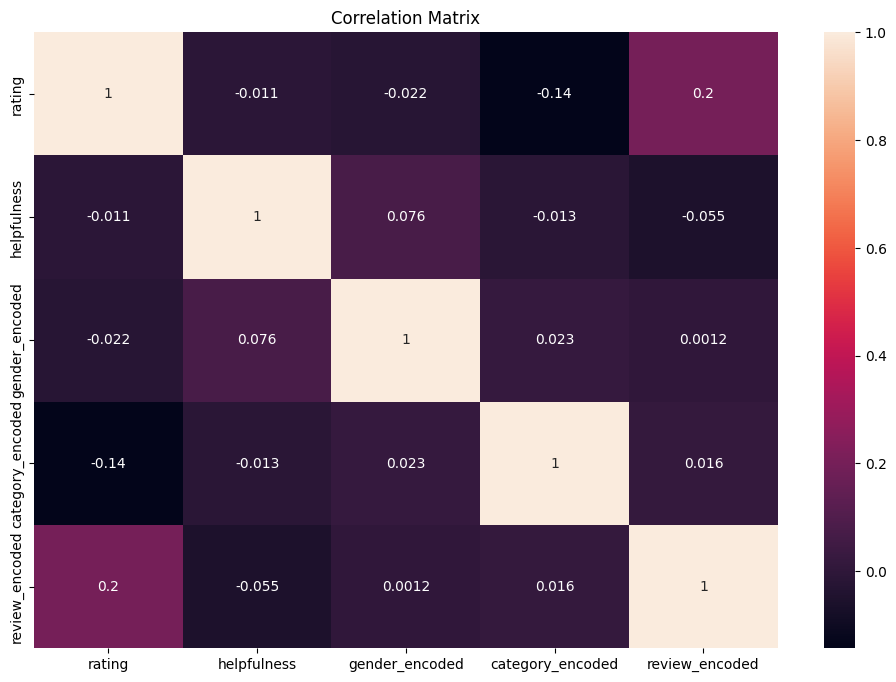

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

## Logistic Regression Model

##### 1. Splitting the dataset into training and testing data

The dataset is split into training and testing data. 75% of the data is being used to train the model while 25% of the data is going to test it.

In [7]:
X = corr_data.drop(columns=['rating'])
Y = corr_data["rating"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=156)

#### 2. Training Logistic Regression Model

In [8]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, Y_train)

Y_pred_log_reg = logistic_regression_model.predict(X_test)

#### 3. Evaluating accuracy score of Logistic Regression Model

The accuracy of the Logistic regression model is calculated. It comes out to be 0.68 which is not poor but not good either. The model is accurate only two-thirds of the time.

In [9]:
log_reg_accuracy = accuracy_score(Y_test, Y_pred_log_reg)
print("Accuracy:", log_reg_accuracy)


Accuracy: 0.6845238095238095


The confusion matrix for the Logistic Regression Model shows the differences between the True values and Predicted values. The model predicts 1 most of the time when the true value is 1. However, it also predicts 1 a lot when the true value is 0. This seems to be the issue with this model.

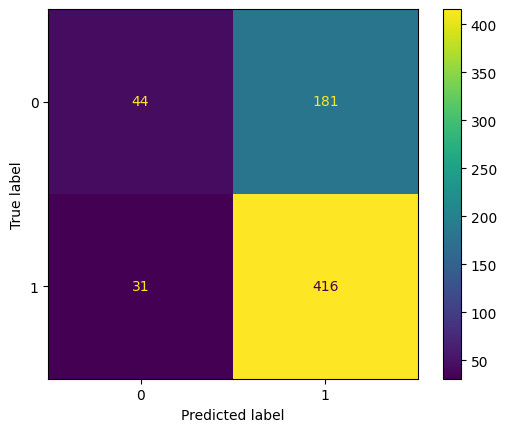

In [10]:
log_reg_cm = confusion_matrix(Y_test, Y_pred_log_reg)
ConfusionMatrixDisplay(confusion_matrix=log_reg_cm).plot()


## KNN Model

#### 1. Training KNN Model

The same Training and Testing data is used as for the Logistic Regression Model to make this a fair comparison. K is arbitrarily set to 5 for this initial test.

In [11]:
# arbitrarily choosing k
k = 5

knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, Y_train)

Y_pred_knn = knn_model.predict(X_test)


#### 2. Evaluating accuracy score of KNN Model

The accuracy of this KNN model comes out to under 0.61. This is worse than the Logistic Regression Model, although still not a poor estimator.

In [12]:
knn_accuracy = accuracy_score(Y_test, Y_pred_knn)
print("Accuracy:", knn_accuracy)


Accuracy: 0.6071428571428571


The confusion matrix for the KNN Model shows that it predicts 0s better than the Logistic regression model but it is worse at predicting 1s.

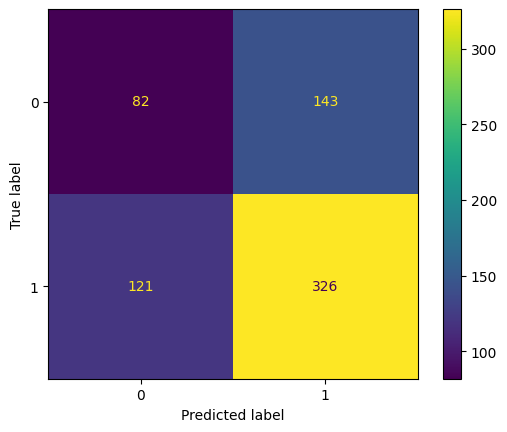

In [13]:
knn_cm = confusion_matrix(Y_test, Y_pred_knn)
ConfusionMatrixDisplay(confusion_matrix=knn_cm).plot()


## Tuning KNN Model

#### 1. Looping through a range of reasonably possible values of K to determine most accurate k 

Again very arbitrary but the possible range of K values is set from 1 to 50. The assumption is that the most optimal value of k should not be a very high value. The process is simply to loop through each value of k and determining accuracies of each. 

In [14]:
k_values = range(1, 50)

accuracy_scores = []

for k in k_values:
    knn_model_temp = KNeighborsClassifier(n_neighbors=k)
    knn_model_temp.fit(X_train, Y_train)
    Y_pred_temp = knn_model_temp.predict(X_test)
    temp_accuracy = accuracy_score(Y_test, Y_pred_temp)
    accuracy_scores.append(temp_accuracy)


#### 2. Plotting Accuracy against the respective k values

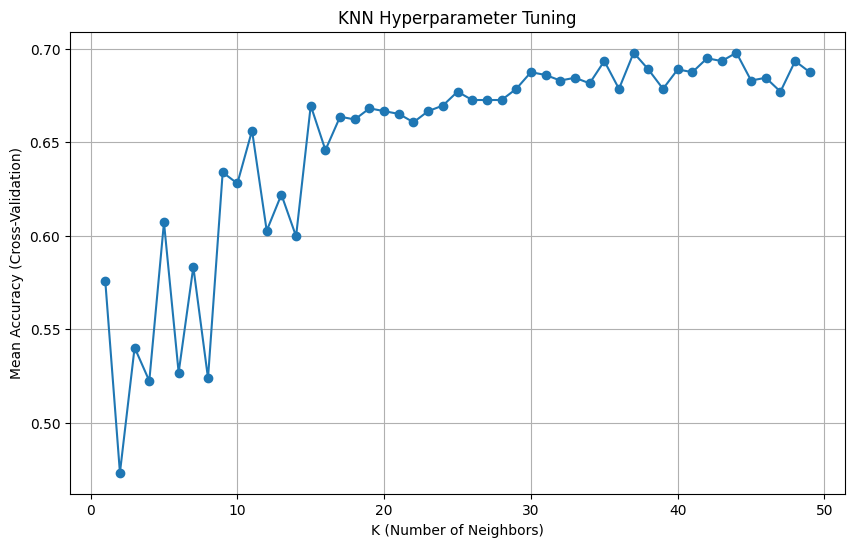

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-')
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Mean Accuracy (Cross-Validation)")
plt.title("KNN Hyperparameter Tuning")
plt.grid(True)
plt.show()


The optimal value of k comes out to be 37 and the accuracy for the model with k=37 comes out to be 0.697. This is slightly better than even the Logistic Regression Model.

In [16]:
optimal_k = k_values[np.argmax(accuracy_scores)]
final_knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
final_knn_model.fit(X_train, Y_train)
Y_pred_optimal = final_knn_model.predict(X_test)
knn_accuracy_optimal = accuracy_score(Y_test, Y_pred_optimal)
print("Optimal K:", optimal_k)
print("Test Accuracy:", knn_accuracy_optimal)


Optimal K: 37
Test Accuracy: 0.6979166666666666


The confusion matrix for the knn model with fine tuned k shows that it has gotten much better at predicting 1s but has somehow gotten a little worse at predicting 0s.

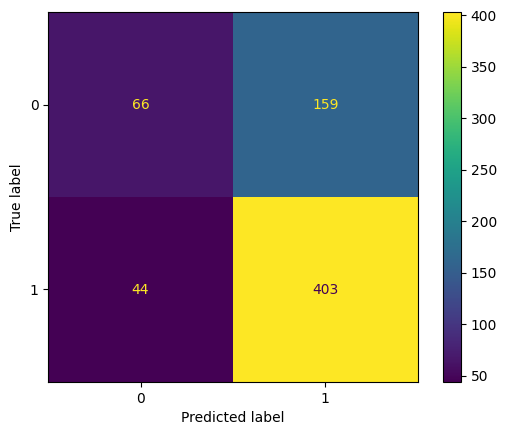

In [17]:
knn_cm_optimal = confusion_matrix(Y_test, Y_pred_optimal)
ConfusionMatrixDisplay(confusion_matrix=knn_cm_optimal).plot()

## Conclusion

The difference in performance of Logistic Regression Model and KNN Model is quite visible through the above tests. The accuracy of KNN Model depends on the value of K. Logistic Regression has no such constraint. It is observed that the ability to predict 1s or 0s is mutually exclusive. Being good at predicting 1s does not mean the model will be good at predicting 0s. 

The performance of both models may also depend on feature selection. In this case, all relevant features were included in training and testing. Another method could be to only use some of these features, selected based on their correlation. RFE function can be used by selecting the n best features. However, this was not done because other than "review", there is no obvious second choice, and training a model using only a single feature will not yield satisfactory results. 

All in all, both models performed similarly and were actually more accurate than my initial prediction based on the correlation matrix.